In [1]:
#!pip3 install matplotlib_venn

In [58]:
import pandas as pd
import numpy as np
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from fuzzywuzzy import fuzz
import jellyfish
from fuzzywuzzy import process

In [3]:
left = pd.read_csv('left_dataset.csv')
right = pd.read_csv('right_dataset.csv')


In [68]:
left_df = left_df[0:10]
right_df = right_df[:10]

In [4]:
left.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98509 entries, 0 to 98508
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   business_id  98509 non-null  int64  
 1   name         98509 non-null  object 
 2   address      98509 non-null  object 
 3   city         98509 non-null  object 
 4   state        98509 non-null  object 
 5   zip_code     98509 non-null  object 
 6   size         98509 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 5.3+ MB


In [5]:
right.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94585 entries, 0 to 94584
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   entity_id    94585 non-null  int64  
 1   name         94585 non-null  object 
 2   address      91787 non-null  object 
 3   city         94585 non-null  object 
 4   state        94585 non-null  object 
 5   postal_code  94548 non-null  float64
 6   categories   94523 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 5.1+ MB


In [6]:
left.head()

,business_id,name,address,city,state,zip_code,size
0,1,SOURINI PAINTING INC.,12800 44th St N,Clearwater,FL,33762-4726,11.0
1,2,WOLFF DOLLA BILL LLC,1905 E 19th Ave,Tampa,FL,33605-2700,8.0
2,3,"COMPREHENSIVE SURGERY CENTER, LLC","1988 GULF TO BAY BLVD, Ste 1",CLEARWATER,FL,33765-3550,8.0
3,4,FRANK & ADAM APPAREL LLC,13640 Wright Cir,Tampa,FL,33626-3030,12.0
4,5,MORENO PLUS TRANSPORT INC,8608 Huron Court unite 58,Tampa,FL,33614,8.0


In [7]:
right.head()

,entity_id,name,address,city,state,postal_code,categories
0,1,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123.0,"Shipping Centers, Local Services, Notaries, Ma..."
1,2,St Honore Pastries,935 Race St,Philadelphia,PA,19107.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
2,3,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054.0,"Brewpubs, Breweries, Food"
3,4,Sonic Drive-In,615 S Main St,Ashland City,TN,37015.0,"Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
4,5,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144.0,"Sporting Goods, Fashion, Shoe Stores, Shopping..."


## Reformat case

In [8]:
right.isnull().sum()

entity_id         0
name              0
address        2798
city              0
state             0
postal_code      37
categories       62
dtype: int64

In [9]:
right['postal_code'] = right['postal_code'].astype(str).str.replace('.0', '')
left = left.apply(lambda x: x.astype(str).str.lower())
right = right.apply(lambda x: x.astype(str).str.lower())

/var/folders/gr/f5m4xwn94f30827t7nnxzvy40000gn/T/ipykernel_86490/823455782.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  right['postal_code'] = right['postal_code'].astype(str).str.replace('.0', '')


## EDA

In [10]:
left['business_id'] = left['business_id'].astype(np.uint8,errors='ignore')
right['entity_id'] = right['entity_id'].astype(np.uint8,errors='ignore')

In [11]:
left_count_unique = { 'attribute': ['name','address','city','state','zip_code'],
                      'unique_count': [left['name'].nunique(),left['address'].nunique()
                    ,left['city'].nunique(), left['state'].nunique()
                    , left['zip_code'].nunique()]}

In [12]:
left_count_unique = pd.DataFrame(left_count_unique)

In [13]:
left_count_unique

,attribute,unique_count
0,name,86341
1,address,80913
2,city,44
3,state,5
4,zip_code,40064


In [14]:
left_count_unique = left_count_unique.sort_values('unique_count',ascending=False)

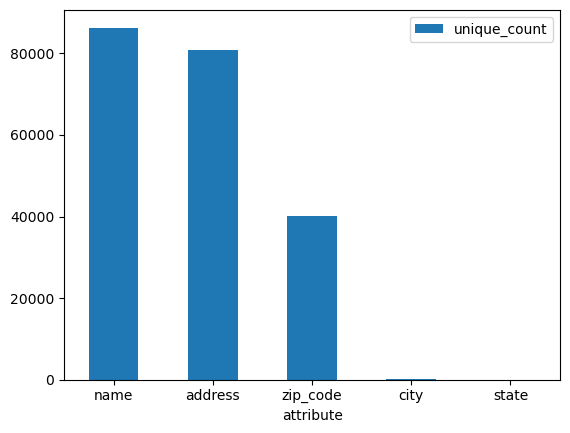

In [15]:
ax = left_count_unique.plot.bar(x='attribute', y='unique_count', rot=0)

In [16]:
right_count_unique = {'attribute': ['name','address','city','state','postal_code'],
                      'unique_count': [right['name'].nunique(),right['address'].nunique()
                    ,right['city'].nunique(), right['state'].nunique()
                    , right['postal_code'].nunique()]}

In [17]:
right_count_unique = pd.DataFrame(right_count_unique)
right_count_unique = right_count_unique.sort_values('unique_count',ascending=False)
right_count_unique

,attribute,unique_count
1,address,77114
0,name,71975
2,city,794
4,postal_code,615
3,state,5


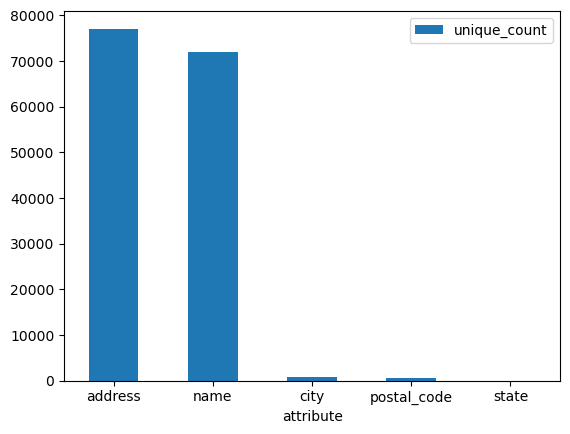

In [18]:
ax = right_count_unique.plot.bar(x='attribute', y='unique_count', rot=0)

#### Name similarity

In [19]:
l_name = left['name']
r_name = right['name']
merge = pd.merge(l_name, r_name, on='name', how='outer', indicator=True)
merge[merge['_merge'] == 'both']

,name,_merge
61,nutrition solutions,both
62,nutrition solutions,both
73,velocity air conditioning,both
243,mary jo's performing arts academy,both
322,beryl project engineering,both
...,...,...
98801,gyro plus,both
98893,gyro star,both
98918,lee house,both
98927,american legion post 82,both


Text(0.3, -0.25, '98.6%')

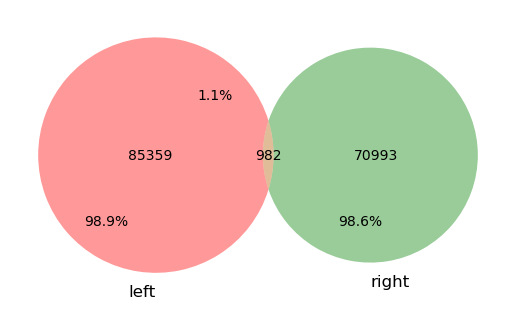

In [20]:
l_name = set(left['name'])
r_name = set(right['name'])
venn2([l_name, r_name], set_labels=('left', 'right'))
ab = len(l_name & r_name) / len(l_name) * 100
a_not_b = len(l_name - r_name) / len(l_name) * 100
b_not_a = len(r_name - l_name) / len(r_name) * 100
plt.text(-0.2, 0.2, f"{ab:.1f}%", fontsize=10)
plt.text(-0.6, -0.25, f"{a_not_b:.1f}%", fontsize=10)
plt.text(0.3, -0.25, f"{b_not_a:.1f}%", fontsize=10)

#### Address similarity

Text(0.3, -0.25, '87.0%')

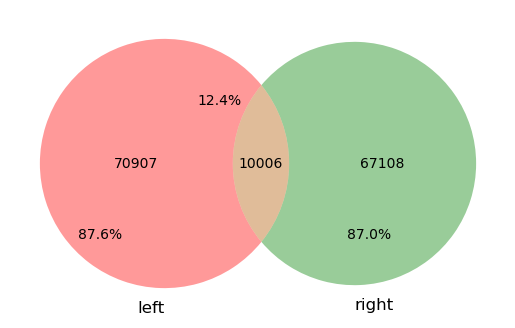

In [21]:
l_add = set(left['address'])
r_add = set(right['address'])
venn2([l_add, r_add], set_labels=('left', 'right'))
ab = len(l_add & r_add) / len(l_add) * 100
a_not_b = len(l_add - r_add) / len(l_add) * 100
b_not_a = len(r_add - l_add) / len(r_add) * 100
plt.text(-0.2, 0.2, f"{ab:.1f}%", fontsize=10)
plt.text(-0.6, -0.25, f"{a_not_b:.1f}%", fontsize=10)
plt.text(0.3, -0.25, f"{b_not_a:.1f}%", fontsize=10)

#### State similarity

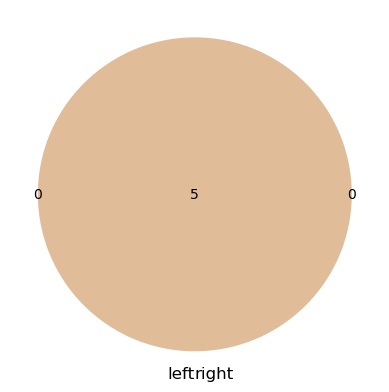

In [22]:
l_s = set(left['state'])
r_s = set(right['state'])
venn2([l_s, r_s], set_labels=('left', 'right'))

In [23]:
##left['zip_code'] = left['zip_code'].str.split('-').str[0]

#### City similarity

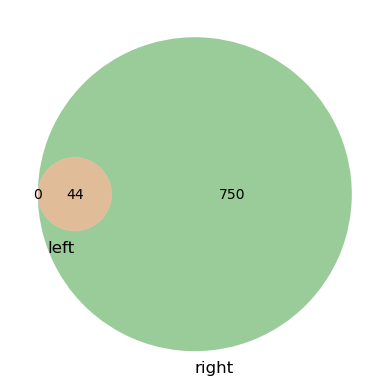

In [24]:
l_c = set(left['city'])
r_c = set(right['city'])
venn2([l_c, r_c], set_labels=('left', 'right'))

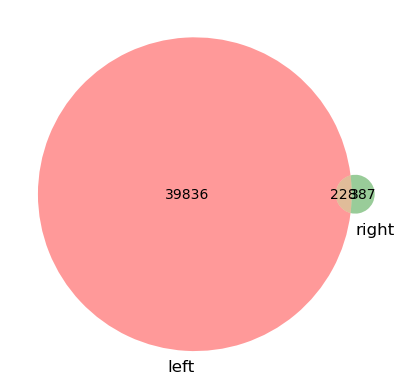

In [25]:
l_zipcode = set(left['zip_code'])
r_postalcode = set(right['postal_code'])
venn2([l_zipcode, r_postalcode], set_labels=('left', 'right'))

In [26]:
left['zip_code']

0        33762-4726
1        33605-2700
2        33765-3550
3        33626-3030
4             33614
            ...    
98504    37209-2135
98505         37207
98506    37206-3907
98507    37207-1236
98508    37207-4534
Name: zip_code, Length: 98509, dtype: object

In [27]:
name_similar = len(l_name & r_name)
address_similar = len(l_add & r_add)
state_similar = len(l_s & r_s)
city_similar = len(l_c & r_c)
postalcode_similar = len(l_zipcode & r_postalcode)

In [28]:
similarity_count = {'attribute_similar': ['name','address','state','city','postal_code'],
                      'similarity_count': [len(l_name & r_name),
                                           len(l_add & r_add),
                                           len(l_s & r_s),
                                           len(l_c & r_c),
                                           len(l_zipcode & r_postalcode)]}

In [29]:
similarity_pct = {'attribute_similar': ['name','address','state','city','postal_code'],
                      'similarity_pct': [(len(l_name & r_name)/len(l_name))*100,
                                           (len(l_add & r_add)/len(l_add))*100,
                                           (len(l_s & r_s)/len(l_s))*100,
                                           (len(l_c & r_c)/len(l_c))*100,
                                           (len(l_zipcode & r_postalcode)/len(l_zipcode))*100]}

In [30]:
similarity_count = pd.DataFrame(similarity_count)
similarity_count = similarity_count.sort_values('similarity_count',ascending=False)
similarity_count

,attribute_similar,similarity_count
1,address,10006
0,name,982
4,postal_code,228
3,city,44
2,state,5


In [31]:
similarity_pct = pd.DataFrame(similarity_pct)
similarity_pct = similarity_pct.sort_values('similarity_pct',ascending=False)
similarity_pct

,attribute_similar,similarity_pct
2,state,100.000000
3,city,100.000000
1,address,12.366369
0,name,1.137351
4,postal_code,0.569089


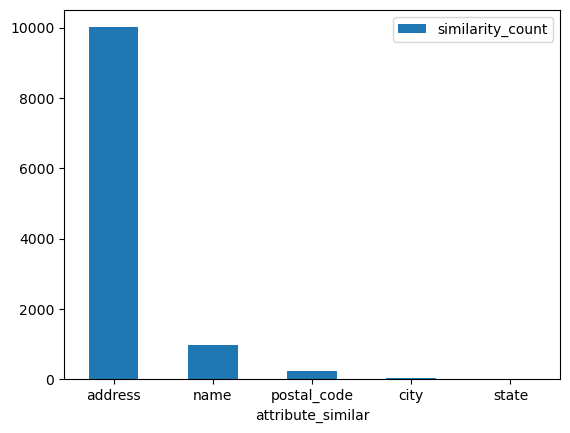

In [32]:
ax = similarity_count.plot.bar(x='attribute_similar', y='similarity_count', rot=0)

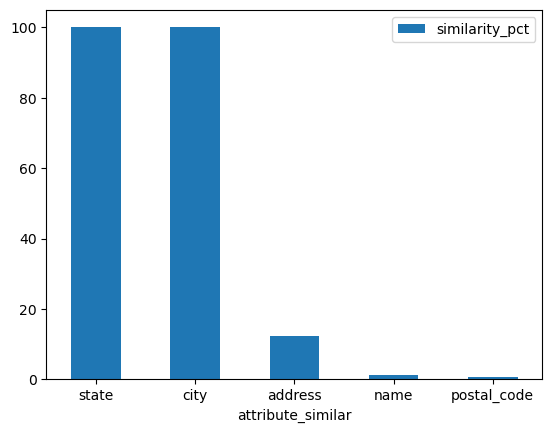

In [33]:
ax = similarity_pct.plot.bar(x='attribute_similar', y='similarity_pct', rot=0)

In [34]:
#right = right[['entity_id','combine']]
#left = left[['business_id','combine']]z

In [35]:
#left_tokens = [set(word.lower().split()) for word in left['name']]
#right_tokens = [set(word.lower().split()) for word in right['name']]

In [36]:
right['combine'] = right['name'] + right['address']+ right['city']+ right['state']+ right['postal_code']
right

,entity_id,name,address,city,state,postal_code,categories,combine
0,1,the ups store,87 grasso plaza shopping center,affton,mo,63123,"shipping centers, local services, notaries, ma...",the ups store87 grasso plaza shopping centeraf...
1,2,st honore pastries,935 race st,philadelphia,pa,197,"restaurants, food, bubble tea, coffee & tea, b...",st honore pastries935 race stphiladelphiapa197
2,3,perkiomen valley brewery,101 walnut st,green lane,pa,154,"brewpubs, breweries, food",perkiomen valley brewery101 walnut stgreen lan...
3,4,sonic drive-in,615 s main st,ashland city,tn,315,"burgers, fast food, sandwiches, food, ice crea...",sonic drive-in615 s main stashland citytn315
4,5,famous footwear,"8522 eager road, dierbergs brentwood point",brentwood,mo,63144,"sporting goods, fashion, shoe stores, shopping...","famous footwear8522 eager road, dierbergs bren..."
...,...,...,...,...,...,...,...,...
94580,117,adelita taqueria & restaurant,1108 s 9th st,philadelphia,pa,19147,"restaurants, mexican",adelita taqueria & restaurant1108 s 9th stphil...
94581,118,inspcenter/thai clinical massage,"2625 n meridian st, unit 50",indianapolis,in,468,"massage therapy, rolfing, beauty & spas, refle...",inspcenter/thai clinical massage2625 n meridia...
94582,119,wild birds unlimited,2813 bransford ave,nashville,tn,374,"pets, nurseries & gardening, pet stores, hobby...",wild birds unlimited2813 bransford avenashvill...
94583,120,claire's boutique,"6020 e 82nd st, ste 46",indianapolis,in,462,"shopping, jewelry, piercing, toy stores, beaut...","claire's boutique6020 e 82nd st, ste 46indiana..."


In [37]:
left['combine'] = left['name'] + left['address']+ left['city']+ left['state']+ left['zip_code']
left = left.drop(["size"],axis=1)
left

,business_id,name,address,city,state,zip_code,combine
0,1,sourini painting inc.,12800 44th st n,clearwater,fl,33762-4726,sourini painting inc.12800 44th st nclearwater...
1,2,wolff dolla bill llc,1905 e 19th ave,tampa,fl,33605-2700,wolff dolla bill llc1905 e 19th avetampafl3360...
2,3,"comprehensive surgery center, llc","1988 gulf to bay blvd, ste 1",clearwater,fl,33765-3550,"comprehensive surgery center, llc1988 gulf to ..."
3,4,frank & adam apparel llc,13640 wright cir,tampa,fl,33626-3030,frank & adam apparel llc13640 wright cirtampaf...
4,5,moreno plus transport inc,8608 huron court unite 58,tampa,fl,33614,moreno plus transport inc8608 huron court unit...
...,...,...,...,...,...,...,...
98504,201,tm inc. llc,4911 georgia ave,nashville,tn,37209-2135,tm inc. llc4911 georgia avenashvilletn37209-2135
98505,202,"passion transportation services, llc",2005 quail dr,nashville,tn,37207,"passion transportation services, llc2005 quail..."
98506,203,rosie cleaning service/commercial,705 n 9th st,nashville,tn,37206-3907,rosie cleaning service/commercial705 n 9th stn...
98507,204,vicky bibbs,1249 dalemere dr,nashville,tn,37207-1236,vicky bibbs1249 dalemere drnashvilletn37207-1236


### 1.1 Combine Name and Address then find accuracy as a whole

In [38]:
#fix zip_code to prepare for tokenization
left['zip_code'] = left['zip_code'].str.replace('-',' ')

## Generate algorithm

In [44]:
#keep only required fields
left_df = left
right_df = right.drop(['categories'], axis=1)

In [45]:
# Rename any columns with similar names to allow merging.
left_df = left_df.rename(columns={'business_id':'id'})
right_df = right_df.rename(columns={'entity_id':'id','postal_code':'zip_code'})

In [46]:
import re

def preprocess_dataframe(df):
    def clean_string(s):
        return str(s).lower().replace(',', '').replace(' ', '').replace('[^a-zA-Z0-9\s]', '')

    def clean_address(s):
        return re.sub(r'(.*), ([A-Z]{2}) (\d{5})(-\d{4})?', r'\1, \2\3', s)

    for col in ['name', 'address']:
        #df[col] = df[col].str.lower().str.replace('[^a-zA-Z0-9\s]', '')
        df[col] = df[col].apply(clean_string)

    df['address'] = df['address'].apply(clean_address)

    df = df.dropna()

    return df

In [47]:
left_df_clean = preprocess_dataframe(left_df)
right_df_clean = preprocess_dataframe(right_df)


In [52]:
left_df_clean = left_df_clean [:500]
right_df_clean = right_df_clean[:500]

In [53]:
left_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 1 to 9981
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        500 non-null    uint8 
 1   name      500 non-null    object
 2   address   500 non-null    object
 3   city      500 non-null    object
 4   state     500 non-null    object
 5   zip_code  500 non-null    object
 6   combine   500 non-null    object
dtypes: object(6), uint8(1)
memory usage: 24.1+ KB


# METHOD - 1 fuzzywuzzy technique

In [54]:
# Matching
matches = []
for left_idx, left_row in left_df_clean.iterrows():
    for right_idx, right_row in right_df_clean.iterrows():
        name_similarity = fuzz.token_sort_ratio(left_row['name'], right_row['name']) / 100
        address_similarity = fuzz.ratio(left_row['address'], right_row['address']) / 100
        confidence_score = 0.6 * name_similarity + 0.4 * address_similarity
        if confidence_score >= 0.8:
            matches.append({'left_id': left_row['id'], 'right_id': right_row['id'], 'confidence_score': confidence_score})
            #matches.append({'left_id': left_row['name'], 'right_id': right_row['name'], 'confidence_score': confidence_score})

# Postprocessing
matches_df = pd.DataFrame(matches).sort_values(by='confidence_score', ascending=False)
matches_df.drop_duplicates(subset=['left_id'], keep='first', inplace=True)
matches_df.reset_index(drop=True, inplace=True)

# Output
matches_df.to_csv('matches_fuzzy.csv', index=False)

# Method -2 JW_similarity

In [59]:
def jw_similarity(s1, s2):
    s1 = str(s1).lower()
    s2 = str(s2).lower()
    return jellyfish.jaro_winkler(s1, s2)

In [60]:
#Define a function to find approximate matches between the two datasets
def find_matches(left_df, right_df, threshold=0.8):
    # Initialize an empty list to store the results
    results = []
    
    # Loop over each row in the left dataset
    for i, left_row in left_df_clean.iterrows():
        # Loop over each row in the right dataset
        for j, right_row in right_df_clean.iterrows():
            # Calculate the Jaro-Winkler similarity score between the business names and addresses
            name_score = jw_similarity(left_row['name'], right_row['name'])
            addr_score = jw_similarity(left_row['address'], right_row['address'])
            # Calculate the overall similarity score as the average of the name and address scores
            score = (name_score + addr_score) / 2
            # If the score is above the threshold, add the match to the results list
            if score >= threshold:
                results.append({'left_id': left_row['id'], 'right_id': right_row['id'], 'score': score})
    
    # Return the results as a pandas DataFrame
    return pd.DataFrame(results)

In [61]:
# Find the matches between the two datasets
matches = find_matches(left_df_clean, right_df_clean, threshold=0.8)
# Save the matches to a CSV file
matches.to_csv('matches_jw.csv', index=False)

# Method - 3 with list comprehension and jwsimilarity to increase computation

In [62]:
# Define a function to find approximate matches between the two datasets
def find_matches(left_df, right_df, threshold=0.8):
    # Calculate the Jaro-Winkler similarity scores for all rows in both data frames
    name_scores = [jw_similarity(left_row['name'], right_row['name']) for _, left_row in left_df.iterrows() for _, right_row in right_df.iterrows()]
    addr_scores = [jw_similarity(left_row['address'], right_row['address']) for _, left_row in left_df.iterrows() for _, right_row in right_df.iterrows()]
    # Calculate the overall similarity scores as the average of the name and address scores
    scores = [(name_score + addr_score) / 2 for name_score, addr_score in zip(name_scores, addr_scores)]
    # Create a list of matches where the score is above the threshold
    matches = [{'left_id': left_df.iloc[i]['id'], 'right_id': right_df.iloc[j]['id'], 'score': score} for i, (_, left_row) in enumerate(left_df.iterrows()) for j, (_, right_row) in enumerate(right_df.iterrows()) for score in [scores[i * len(right_df) + j]] if score >= threshold]
    # Return the matches as a pandas DataFrame
    return pd.DataFrame(matches)

In [63]:
# Find the matches between the two datasets
matches = find_matches(left_df_clean, right_df_clean, threshold=0.8)
# Save the matches to a CSV file
matches.to_csv('matches_jw_list.csv', index=False)

# Method 4- fuzzywuzzy with Combined address + city + State + zip code

In [69]:
# Concatenate city, state, and zip code into the address column
left_df['full_address'] = (left_df['address'] + ' '
                           + left_df['city'].fillna('') + ' '
                           + left_df['state'].fillna('') + ' '
                           + left_df['zip_code'].fillna('').str.replace('-', '').astype(str))

right_df['full_address'] = (right_df['address'] + ' '
                            + right_df['city'].fillna('') + ' '
                            + right_df['state'].fillna('') + ' '
                            + right_df['zip_code'].astype(str).fillna('').str.replace('-', ''))


# Preprocess the address column
left_df['full_address'] = left_df['full_address'].apply(lambda x: process.extractOne(x, choices=left_df['full_address'], scorer=fuzz.token_sort_ratio)[0])
right_df['full_address'] = right_df['full_address'].apply(lambda x: process.extractOne(x, choices=right_df['full_address'], scorer=fuzz.token_sort_ratio)[0])


# Matching
matches = []
for left_idx, left_row in left_df.iterrows():
    for right_idx, right_row in right_df.iterrows():
        name_similarity = fuzz.token_sort_ratio(left_row['name'], right_row['name']) / 100
        address_similarity = fuzz.token_sort_ratio(left_row['full_address'], right_row['full_address']) / 100
        confidence_score = 0.6 * name_similarity + 0.4 * address_similarity
        if confidence_score >= 0.8:
            matches.append({'entity_id': left_row['id'], 'business_id': right_row['id'], 'confidence_score': confidence_score})

# Output
matches_df4 = pd.DataFrame(matches)
matches_df4.to_csv('matches_added.csv', index=False)


# Method 5 - with LSH

In [71]:
from fuzzywuzzy import fuzz, process
from joblib import Parallel, delayed

# Define a function to preprocess the full_address column
def preprocess_address(address):
    return process.extractOne(address, choices=address_series, scorer=fuzz.token_sort_ratio)[0]

# Concatenate city, state, and zip code into the address column
left_df['full_address'] = left_df['address'].str.cat([left_df['city'].fillna(''), left_df['state'].fillna(''), left_df['zip_code'].fillna('').str.replace('-', '').astype(str)], sep=' ')
right_df['full_address'] = right_df['address'].str.cat([right_df['city'].fillna(''), right_df['state'].fillna(''), right_df['zip_code'].astype(str).fillna('').str.replace('-', '')], sep=' ')


In [72]:
# Create a series of all the addresses to use for preprocessing
address_series = pd.concat([left_df['full_address'], right_df['full_address']])

# Preprocess the address column using parallel processing
preprocessed_addresses = Parallel(n_jobs=-1)(delayed(preprocess_address)(address) for address in address_series)


/Users/arshithas/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/arshithas/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/arshithas/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/arshithas/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python 

In [73]:
# Update the full_address column with the preprocessed addresses
left_df['full_address'] = preprocessed_addresses[:len(left_df)]
right_df['full_address'] = preprocessed_addresses[len(left_df):]

# Define a function to match the rows
def match_rows(left_row, right_df):
    matches = []
    for right_idx, right_row in right_df.iterrows():
        name_similarity = fuzz.token_sort_ratio(left_row['name'], right_row['name']) / 100
        address_similarity = fuzz.token_sort_ratio(left_row['full_address'], right_row['full_address']) / 100
        confidence_score = 0.6 * name_similarity + 0.4 * address_similarity
        if confidence_score >= 0.8:
            matches.append({'entity_id': left_row['id'], 'business_id': right_row['id'], 'confidence_score': confidence_score})
    return matches

# Use parallel processing to match the rows
matches = Parallel(n_jobs=-1)(delayed(match_rows)(left_row, right_df) for left_idx, left_row in left_df.iterrows())

# Flatten the list of matches and convert it to a pandas DataFrame
matches_df = pd.DataFrame([match for matches_list in matches for match in matches_list])

# Output the matches to a CSV file
matches_df.to_csv('matches_parallel.csv', index=False)